In [1]:
%matplotlib inline

In [2]:
import itertools
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib import animation
import numpy as np
import pandas as pd
from numpy import genfromtxt


from IPython.display import HTML
import seaborn as sns
from dataclasses import dataclass
import desert
from typing import List, Union
from collections import defaultdict, namedtuple
from tqdm.notebook import trange, tqdm

In [3]:
data = pd.read_csv("../resources/TB3MS.csv", parse_dates=["DATE"])
r = genfromtxt("../treasury_bill_output_r.txt", filling_values=0, delimiter=",")
change_points = np.loadtxt("../treasury_bill_output_change_points.txt").astype(np.uint)

In [4]:
r

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-03, 9.96000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-03, 5.87356572e-08, 9.95999941e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.00000000e-03, 1.69802489e-08, 4.55543570e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-03, 1.68763912e-08, 4.46368788e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-03, 1.66379375e-08, 4.37808485e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [5]:
max_length = np.where(np.sum(r, axis=0) < 1E-4)[0][0]
max_length

178

(0.0, 178.0)

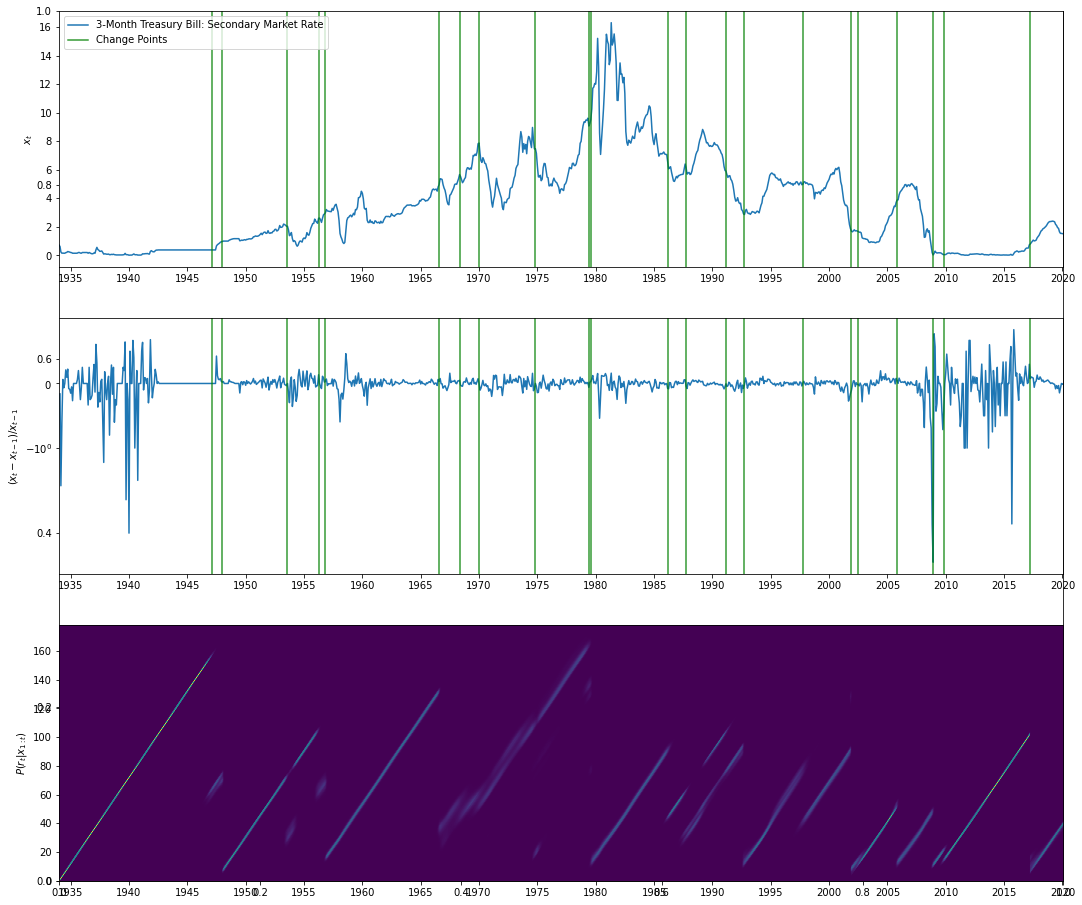

In [6]:
fig, ax = plt.subplots(figsize=[18, 16], sharex=True)

ax = fig.add_subplot(3, 1, 1)
ax.plot("DATE", "TB3MS", data=data, label="3-Month Treasury Bill: Secondary Market Rate")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

#ax.set_yscale('symlog', linthreshy=20)
ax.set_ylabel("$x_t$")
for change_point in change_points:
    line = ax.axvline(data.DATE.iloc[change_point], color="green", alpha=0.8)
line.set_label("Change Points")
ax.legend()

ax = fig.add_subplot(3, 1, 2, sharex=ax)
pct_changes = np.diff(data["TB3MS"]) /data["TB3MS"].values[1:]
ax.set_yscale("symlog")
ax.set_ylabel("$(x_t - x_{t-1}) / x_{t-1}$")
ax.plot(data["DATE"].values[1:], pct_changes, label="")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

for change_point in change_points:
    line = ax.axvline(data.DATE.iloc[change_point], color="green", alpha=0.8)

ax = fig.add_subplot(3, 1, 3, sharex=ax)
x_lims = mdates.date2num([data.DATE.min(), data.DATE.max()])
#rp = np.rot90(r, 1)
#rp[np.isinf(rp)] = np.min(rp[np.isfinite(rp)])

ax.imshow(
    np.transpose(r),
    cmap=cm.viridis,
    extent = [x_lims[0], x_lims[1], 0, r.shape[1]],
    aspect="auto",
    origin="lower",
)
ax.set_ylabel("$P(r_t|x_{1:t})$")
ax.set_ylim(0, max_length)

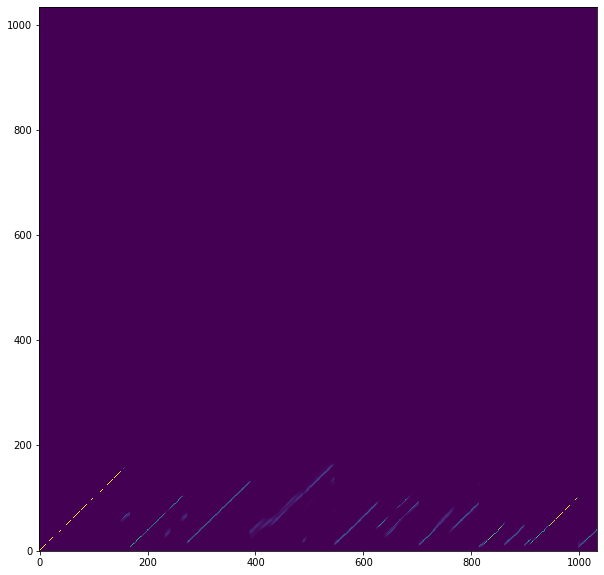

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(r), origin="lower", aspect="auto", interpolation="nearest")

In [8]:
from scipy.special import logsumexp

def trace_path(r):
    path = [0]
    n = len(r)
    for step in range(1, n):
        s = path[-1]
        ps = np.copy(r[step, :step + 1])
        #print(step, s, ps)
        ps /= sum(ps)
        path.append(np.random.choice(range(step + 1), p = ps))
    return path

def path_to_cp(path, min_count=1):
    votes = np.zeros(len(path))
    for i, l in enumerate(path):
        votes[i - l] += 1
    return np.array(votes >= min_count, dtype=np.float64)

def mc_cp_dist(r, n=1000, min_count=1):
    bins = np.zeros(len(r), dtype=np.float64)
    for _i in tqdm(range(n)):
        bins += path_to_cp(trace_path(r), min_count)
    return bins / n

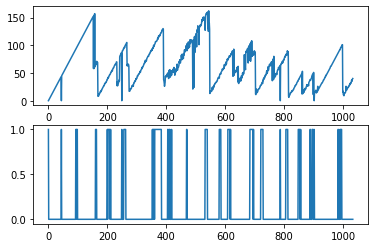

In [9]:
path = trace_path(r)
fig, axs = plt.subplots(2, 1)
axs[0].plot(path)
axs[1].plot(path_to_cp(path, 1))

In [10]:
bins = mc_cp_dist(r, 100, 1)

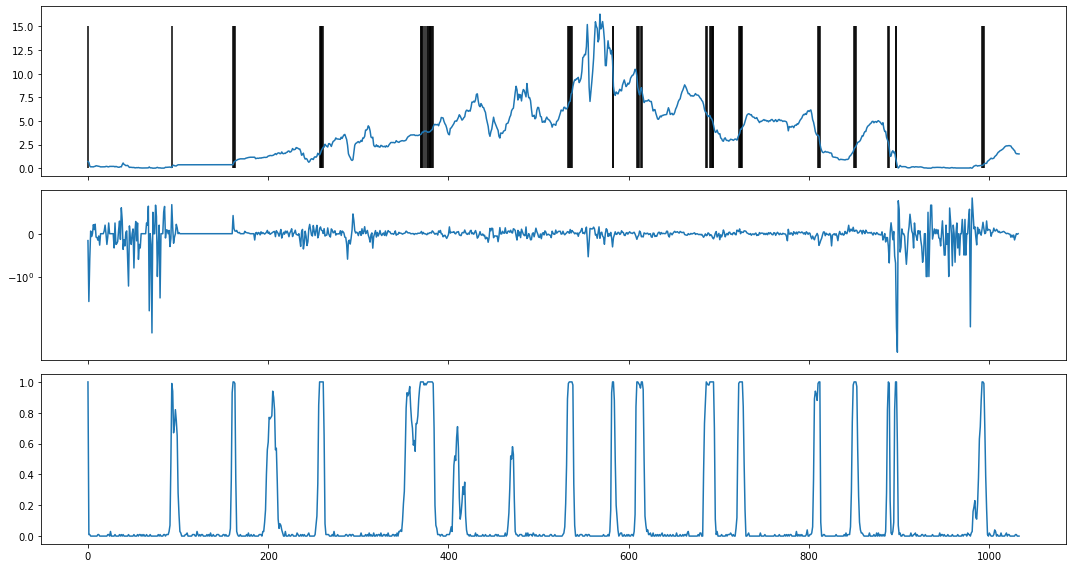

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data["TB3MS"])
axs[1].plot(pct_changes)
axs[1].set_yscale("symlog")
axs[2].plot(bins)
fig.tight_layout()

axs[0].vlines(np.where(bins > 0.98), 0, 15)

In [12]:
370 / 4

92.5

In [14]:
np.where(bins > 0.98)

(array([  0,  93, 161, 162, 163, 257, 258, 259, 260, 261, 369, 370, 371,
        372, 374, 376, 377, 378, 379, 380, 381, 382, 383, 533, 534, 535,
        536, 537, 582, 583, 609, 610, 611, 614, 615, 686, 687, 690, 691,
        692, 693, 694, 722, 723, 724, 725, 726, 810, 811, 812, 850, 851,
        852, 888, 889, 896, 897, 992, 993, 994]),)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


(0.0, 1.0)

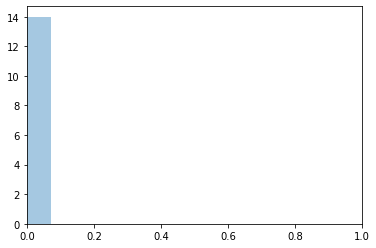

In [15]:
m = 811
sns.distplot(np.diag(r[m:, m:]))
plt.xlim(0, 1)

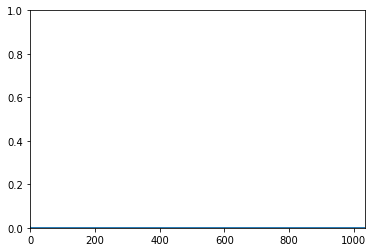

In [16]:
fig, ax = plt.subplots()

ln, = ax.plot(
    np.linspace(0, r.shape[0], r.shape[0]),
    np.zeros(r.shape[0]),
)
def init():
    ax.set_xlim(0, r.shape[0])
    ax.set_ylim(0, 1)
    return ln,

def update(frame):
    y_data = np.zeros(r.shape[0])
    d = np.diag(r[frame:, :])
    y_data[:len(d)] = d
    ln.set_data(
        np.linspace(0, r.shape[0], r.shape[0]),
        y_data
    )
    return ln,

ani = animation.FuncAnimation(
    fig,
    update,
    frames=list(range(r.shape[0])),
    init_func=init,
    blit=True,
    interval=50,
)
    
HTML(ani.to_html5_video())

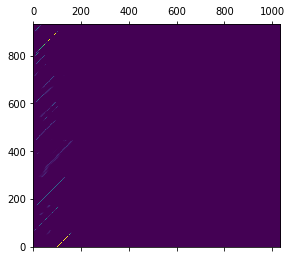

In [17]:
plt.matshow(r[100:, :], origin="lower")

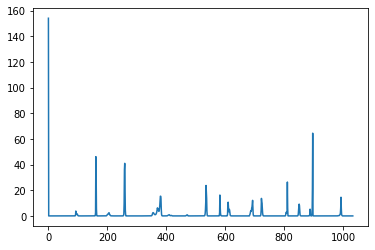

In [18]:
ps = np.zeros(r.shape[0])
for m in range(0, r.shape[0]):
    x = np.sum(np.diag(r[m:, :]))
    ps[m] = x
plt.plot(ps)

In [19]:
np.diag(r[165:, :])

array([4.00000000e-03, 7.43004171e-07, 7.62486898e-06, 6.71764223e-05,
       1.25972379e-04, 9.84377295e-05, 7.58711959e-05, 6.09550556e-05,
       5.06919812e-05, 4.33154707e-05, 3.89287189e-05, 3.61329812e-05,
       3.45307802e-05, 3.36894071e-05, 3.34832961e-05, 3.36466369e-05,
       3.39602444e-05, 3.44143607e-05, 3.50018054e-05, 3.57175926e-05,
       3.65585623e-05, 3.52701295e-05, 3.44182380e-05, 3.40993396e-05,
       3.36306976e-05, 3.36545643e-05, 3.40330572e-05, 3.40940548e-05,
       3.49034442e-05, 3.57946852e-05, 3.71976465e-05, 3.88492515e-05,
       4.04612157e-05, 4.23395714e-05, 4.49844128e-05, 4.94340197e-05,
       5.43662567e-05, 6.04976874e-05, 6.67362069e-05, 7.34349249e-05,
       8.10045529e-05, 8.98734922e-05, 1.00567771e-04, 1.13142657e-04,
       1.25173592e-04, 1.39731684e-04, 1.55957169e-04, 1.73501599e-04,
       1.91209458e-04, 2.10486083e-04, 2.32209077e-04, 2.54322208e-04,
       2.77333964e-04, 3.02849795e-04, 3.29727350e-04, 3.59415407e-04,
      

In [21]:
@dataclass
class GaussianSuffStat:
    n: int
    mean: float
    sx: float

    def observe(self, x):
        self.n += 1
        mean_xn = self.mean + (x - self.mean) / self.n
        self.sx += (x - self.mean) * (x - mean_xn)
        self.mean = mean_xn
    
    def forget(self, x):
        n = self.n
        nm1 = n - 1
        old_mean = n / nm1 * self.mean - x/nm1
        self.sx -= (x - old_mean)*(x - self.mean)
        self.mean = old_mean
        self.n -= 1

In [22]:
suff_stats = []
for i in range(0, 400):
    suff_stats.append(GaussianSuffStat(0, 0, 0))
    for ss in suff_stats:
        ss.observe(pct_changes[i])

In [23]:
suff_stats

[GaussianSuffStat(n=400, mean=-0.020069764810135577, sx=28.212837703782245),
 GaussianSuffStat(n=399, mean=-0.019715828575121733, sx=28.192844474772706),
 GaussianSuffStat(n=398, mean=-0.01578714137723682, sx=25.74180180951307),
 GaussianSuffStat(n=397, mean=-0.01431557246382933, sx=25.39963743585132),
 GaussianSuffStat(n=396, mean=-0.014509551182172334, sx=25.393721903092075),
 GaussianSuffStat(n=395, mean=-0.014377507851831851, sx=25.390994651397193),
 GaussianSuffStat(n=394, mean=-0.014413998988511605, sx=25.39078741401353),
 GaussianSuffStat(n=393, mean=-0.01498636620168716, sx=25.34006052034),
 GaussianSuffStat(n=392, mean=-0.015267551052298833, sx=25.32788009499159),
 GaussianSuffStat(n=391, mean=-0.015874941776786125, sx=25.271334453496202),
 GaussianSuffStat(n=390, mean=-0.015710518550572723, sx=25.2672118867551),
 GaussianSuffStat(n=389, mean=-0.01552736687142475, sx=25.262122844959606),
 GaussianSuffStat(n=388, mean=-0.015180787920062463, sx=25.243993350514927),
 GaussianSuff